# GANITE(Tensorflow): Train and Evaluation

This notebook presents the solution for training and evaluating the __GANITE__ algorithm(__Tensoflow__ version) over the [Twins](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/data/twins/) dataset..

The implementation of GANITE is adapted in the local `ite` library. For the Unified API version, check [this notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/unified_api_train_evaluation.ipynb).

## GANITE

Estimating Individualized Treatment Effects(__ITE__) is the task that approximates whether a given treatment influences or determines an outcome([read more](https://www.vanderschaar-lab.com/individualized-treatment-effect-inference/)).

[__GANITE__](https://openreview.net/pdf?id=ByKWUeWA-)(Generative Adversarial Nets for inference of Individualized Treatment Effects) is a framework for inferring the ITE using GANs.

The implementation demonstrated in this notebook is [here](https://github.com/bcebere/ite-api/tree/main/src/ite/algs/ganite) and is adapted from [this implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/ganite/).

## Setup

First, make sure that all the depends are installed in the current environment.
```
pip install -r requirements.txt
pip install .
```

Next, we import all the dependencies necessary for the task.

In [1]:
# Double check that we are using the correct interpreter.
import sys
print(sys.executable)

# Disable TF logging
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    
# Depends
import ite.algs.ganite.model as alg
import ite.datasets as ds
import ite.utils.tensorflow as utils

from matplotlib import pyplot as plt
import pandas as pd
import tensorflow.compat.v1 as tf

/home/bcebere/anaconda3/envs/cambridge/bin/python
Instructions for updating:
non-resource variables are not supported in the long term


## Load the Dataset

The example is done using the [Twins](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/data/twins/) dataset.

Next, we load the dataset, process the data, and sample a training set and a test set.

The logic is implemented [here](https://github.com/bcebere/ite-api/tree/main/src/ite/datasets), and it adapted from the original [GANITE pre-processing implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/ganite/data_preprocessing_ganite.py).

In [2]:
train_ratio = 0.8
 
dataloader = ds.load("twins", train_ratio)
[Train_X, Train_T, Train_Y, Opt_Train_Y, Test_X, Test_Y] = dataloader


pd.DataFrame(data=Train_X[:5])

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,60.0,1.0,33.0,22.0,12.0,2.0,2.0,1.0,12.0,1.0
1,3.0,2.0,2.0,2.0,2.0,8.0,2.0,2.0,2.0,2.0,...,36.0,1.0,34.0,26.0,12.0,1.0,1.0,3.0,8.0,1.0
2,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,...,8.0,1.0,25.0,23.0,12.0,1.0,1.0,1.0,6.0,1.0
3,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,19.0,1.0,23.0,30.0,12.0,1.0,2.0,1.0,7.0,1.0
4,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,15.0,1.0,29.0,22.0,11.0,2.0,1.0,5.0,4.0,2.0


## Load the model

Next, we define the model.


The constructor supports the following parameters:
 - `dim`: The number of features in X.
 - `dim_outcome`: The number of potential outcomes.
 - `dim_hidden`: hyperparameter for tuning the size of the hidden layer.
 - `depth`: hyperparameter for the number of hidden layers in the generator and inference blocks.
 - `num_iterations`: hyperparameter for the number of training epochs.
 - `alpha`: hyperparameter used for the Generator block loss.
 - `beta`: hyperparameter used for the ITE block loss.
 - `num_discr_iterations`: number of iterations executed by the discriminator.
 - `minibatch_size`: the size of the dataset batches.
 
 The hyperparameters used in this notebook are computed using the [hyperparameter tuning notebook](https://github.com/bcebere/ite-api/blob/main/notebooks/hyperparam_tuning.ipynb).

In [3]:
dim = len(Train_X[0])
dim_outcome = Test_Y.shape[1]
 
model = alg.Ganite(
    dim,  
    dim_outcome, 
    dim_hidden=7, 
    num_iterations=10000, 
    alpha=5, 
    beta=0.1, 
    minibatch_size=32, 
    num_discr_iterations=9, 
    depth=2,
)

assert model is not None

## Train the model

In [4]:
metrics = model.train(*dataloader)

100%|██████████| 10000/10000 [00:07<00:00, 1312.45it/s]


## Plot train metrics

Counterfactual Block:
 - Discriminator loss: 0.706 +/- 0.028
 - Generator loss: -3.499 +/- 0.104
ITE Block:
 - Loss: 0.108 +/- 0.034
ITE Block in-sample metrics:
 - sqrt_PEHE: 0.299 +/- 0.004
 - ATE: 0.033 +/- 0.009
 - MSE: 0.095 +/- 0.024
ITE Block out-sample metrics:
 - sqrt_PEHE: 0.287 +/- 0.004
 - ATE: 0.028 +/- 0.009
 - MSE: 0.095 +/- 0.024


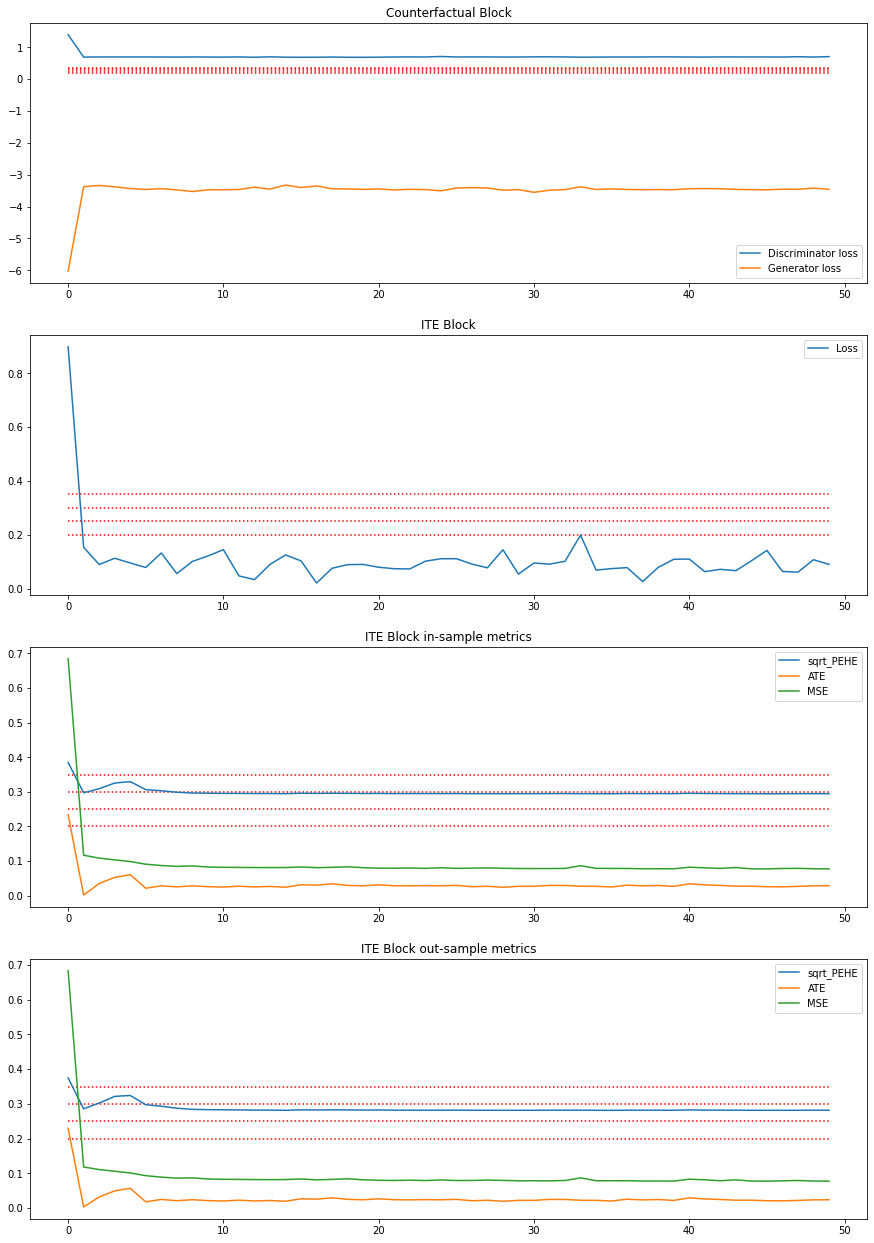

In [5]:
metrics.plot(plt, thresholds = [0.2, 0.25, 0.3, 0.35])

metrics.print()

## Predict

You can use run inferences on the model and evaluate the output.

In [6]:
sess = tf.InteractiveSession()

hat_y = model.predict(Test_X)

utils.sqrt_PEHE(hat_y, Test_Y).eval()

0.2814695971366796

## Test
Will can run inferences and get metrics directly

In [7]:
test_metrics = model.test(Test_X, Test_Y)

test_metrics.print()

sqrt_PHE = 0.281
ATE = 0.022
MSE = 0.078
Top 5 worst mistakes(indices) = [2143  251 2153 1812 1745]


## References

1. Jinsung Yoon, James Jordon, Mihaela van der Schaar, "GANITE: Estimation of Individualized Treatment Effects using Generative Adversarial Nets", International Conference on Learning Representations (ICLR), 2018 ([Paper](https://openreview.net/forum?id=ByKWUeWA-)).
2. [GANITE Reference implementation](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/ganite/).